<a href="https://colab.research.google.com/github/solobala/STPY36/blob/main/STPY36_DZ4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 *Важно! для проверки дз перед началом работы с Kaggle необходимо загрузить в сессионное хранилище свои регистрационные данные - файл kaggle.json -в блоке "Загрузка датасета"*

#Домашнее задание к лекции «Корреляция и корреляционный анализ»

Возьмите датасет Mortality and Water Hardness**
www.kaggle.com...r-hardness

В этом датасете содержатся данные по средней годовой смертности на
100000 населения и концентрации кальция в питьевой воде для 61
большого города в Англии и Уэльсе. Города дополнительно поделены на
северные и южные.

##Задание 1.
Ответить на вопрос: есть ли связь между жёсткостью воды и средней годовой смертностью?

Построить точечный график
Рассчитать коэффициенты корреляции Пирсона и Спирмена
Построить модель линейной регрессии
Рассчитать коэффициент детерминации
Вывести график остатков
##Задание 2.
Ответить на вопрос: сохраняется ли аналогичная зависимость для северных и южных городов по отдельности?

Разделить данные на 2 группы
Повторить аналогичные шаги из пункта 1 для каждой группы по отдельности

### Дополнительные источники информации

Контекст: http://ecologylib.ru/books/item/f00/s00/z0000029/st008.shtml?ysclid=l9k3fcqh7c833149832 
        https://med7.net/info/jestkost__vody/
- о взаимосвязи жесткости воды и смертности

https://github.com/capissimo/python-for-data-science/blob/master/ch03_Correlation.ipynb 

*   ресурс самописных функций для DataScience на GitHub





## Вспомогательные функции

In [ ]:
def shapiro_test(df,names):
    """
    Служебная функция для вывода информации по тесту Шапиро-Уилкса
    """
    seed(1)
    for name in names:
        stat, p = shapiro(df[name])
        print(name)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        alpha = 0.05
        if p > alpha:
            print('Предположительно нормальное распределение (Недостаточно данных, чтобы отвергнуть H0)')
        else:
            print('Отвергаем H0 о нормальности распределения')
        print()

In [ ]:
def statis(df,name):
    """
    Служебная функция для вывода медианы и среднего по выборке, выбросам и выборке без выбросов
    """
    q1 = df[name].quantile(0.25)
    q3 = df[name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr) 
    upper_bound = q3 + (1.5 * iqr)
    mean_mortality = df[name].mean()
    median_mortality = df[name].median()

    remove_outliers = df[df[name].between(lower_bound, upper_bound, 'both')]
    mean_remove_outliers = remove_outliers[name].mean()
    mediana_remove_outliers = remove_outliers[name].median()
    outliers = df[~df[name].between(lower_bound, upper_bound, 'both')] # а что это за выбросы?

    mean_outliers = outliers[name].mean()
    mediana_outliers = outliers[name].median()
    print(f'{name}:')
    print('======================================================')
    print(f'Среднее значение по {name}: {mean_mortality}')
    print(f'Медиана по {name}: {median_mortality}')
    print()
    print(f'Среднее значение по {name} по строкам без выбросов: {mean_remove_outliers}')
    print(f'Медиана по {name} по строкам без выбросов: {mediana_remove_outliers}')
    print()
    print(f'Среднее значение по {name} для выбросов: {mean_outliers}')
    print(f'Медиана по {name} для выбросов: {mediana_outliers}')
    print(f'% выбросов: {round(len(outliers)/len(df)*100,2)}')
    if len(outliers) == 0:
        print(f'В {name} выбросов нет')

In [ ]:
def get_stat(df,names):
  """
  Служебная Функция для расчета и печати основных статистик.
  на входе - имя датафрейма и список названий столбцов
  на выходе- к-во признаков серии за вычетом NAN и 10 основных статистик - 
  max, min, range, mean, mode, std, var, Q1, Q3, iqr
  """
  for name in names:
    count_ = df[name].count()
    max_ = df[name].max() 
    min_ = df[name].min()
    range_ = round(df[name].max() - df[name].min(),1)
    mean_ = df[name].mean()
    mediana_ = df[name].quantile(0.50)
    mode_ = df[name].mode()[0]
    std_ = df[name].std()
    var_ = df[name].var()
    Q1 = df[name].quantile(0.25)
    Q3 = df[name].quantile(0.75) 
    iqr = Q3-Q1
    print(f'{name}:')
    print(f'count = {count_}, max = {max_}, min = {min_}, range = {range_}, mean = {mean_}, mediana = {mediana_},  mode = {mode_}, std = {std_}, var = {var_}, Q1 = {Q1},  Q3 = {Q3}, IQR = {iqr}')
    print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
def t_test_verbose(a, sample2=None, mean=None, fn=None):
    '''Служебная функция с подробной информацией 
       результата t-теста Уэлча'''
    abar = a.mean()
    avar = a.var(ddof=1)  # несмещенное значение
    na = a.size
    adof = na - 1
    conf_int = sst.t.interval(0.95, len(a)-1, 
                                loc=sp.mean(a), scale=sst.sem(a))

    if type(a) == type(sample2):
        bbar = sample2.mean()
        bvar = sample2.var(ddof=1)
        nb = sample2.size
        bdof = nb - 1

        dof = (avar/na + bvar/nb)**2 /   \
              (avar**2/(na**2*adof) + bvar**2/(nb**2*bdof))
        return {'p-значение'           : 
                   fn(a, sample2, equal_var=False).pvalue,  #  выполняет t-тест Уэлша   
                'степени свободы     ' : dof,  #t_test(a, b),   
                'интервал уверенности' : conf_int,         
                'n1          ' : a.count(),
                'n2          ' : sample2.count(),
                'среднее x   ' : a.mean(),
                'среднее y   ' : sample2.mean(),
                'дисперсия x ' : a.var(),
                'дисперсия y ' : sample2.var(),
                't-статистика' : fn( a, sample2, equal_var=False ).statistic} 
    else:
        dof = (avar/na) / (avar/(na*adof))
        return {'p-значение          ' : fn(a, mean).pvalue,    
                'степени свободы df  ' : dof,    
                'интервал уверенности' : conf_int, 
                'n1                  ' : a.count(),
                'среднее x           ' : a.mean(),
                'дисперсия x         ' : a.var(),
                't-статистика        ' : fn(a, mean).statistic} 

### Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np 
from numpy.random import seed
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy as sp
import scipy.stats as sst
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

## Загрузка датасета

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
!pip install -q kaggle # Делаем 1 раз

In [ ]:
# Это напоминалка - приглашение загрузить в сессионное хранилище свой kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marinabalakina","key":"0763a280a2e52ea690b44499c8ab213e"}'}

In [ ]:
! mkdir ~/.kaggle # Создаем каталог .caggle  1 раз, для того, чтобы сюда положить ключ kaggle.json, который получаем на Kaggle при регистрации

In [ ]:
! cp kaggle.json ~/.kaggle/  # кладем

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json # засекречиваем. К сожалению, это все только на время сеанса

In [ ]:
!kaggle datasets download -d 'ukveteran/mortality-and-water-hardness' 

  0% 0.00/0.98k [00:00<?, ?B/s]
100% 0.98k/0.98k [00:00<00:00, 870kB/s]


In [ ]:
! unzip mortality-and-water-hardness  


Archive:  mortality-and-water-hardness.zip
  inflating: water.csv               


In [ ]:
df = pd.read_csv('/content/water.csv')

In [ ]:
df.head()

,Unnamed: 0,location,town,mortality,hardness
0,1,South,Bath,1247,105
1,2,North,Birkenhead,1668,17
2,3,South,Birmingham,1466,5
3,4,North,Blackburn,1800,14
4,5,North,Blackpool,1609,18


In [ ]:
df.info() # Пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  61 non-null     int64 
 1   location    61 non-null     object
 2   town        61 non-null     object
 3   mortality   61 non-null     int64 
 4   hardness    61 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.5+ KB


In [ ]:
get_stat(df,['mortality', 'hardness'])

mortality:
count = 61, max = 1987, min = 1096, range = 891, mean = 1524.1475409836066, mediana = 1555.0,  mode = 1486, std = 187.6687539314571, var = 35219.561202185796, Q1 = 1379.0,  Q3 = 1668.0, IQR = 289.0
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
hardness:
count = 61, max = 138, min = 5, range = 133, mean = 47.18032786885246, mediana = 39.0,  mode = 14, std = 38.0939663624575, var = 1451.1502732240438, Q1 = 14.0,  Q3 = 75.0, IQR = 61.0
-------------------------------------------------------------------------------------------------------------------------------------------------------------------


#### 4 значимых столбца:
 
*   location - категориальный признак для отнесения к северу или югу;
*   town - категориальный признак для отнесения к одному из городов
*   hardness - количественный признак - концентрация кальция (в частях на миллион) в питьевом водоснабжении
*   mortality - количественный признак -ежегодная смертность на 100 000 мужчин






## Задание 1

### Есть ли различия в данных выборки?

In [ ]:
df.hardness.unique()

array([105,  17,   5,  14,  18,  10,  15,  78,  84,  73,  12,  21,  96,
        20,  39, 122,  44,  94,   8,   9,  91, 138,  16,  37,  26,  59,
       133,  27,   6, 107,  90, 101,  13,  49,  68,  50,  75,  71,  57,
        60,  53,  81])

In [ ]:
df.mortality.unique()

array([1247, 1668, 1466, 1800, 1609, 1558, 1807, 1299, 1637, 1359, 1392,
       1755, 1519, 1307, 1254, 1491, 1555, 1428, 1318, 1260, 1723, 1379,
       1742, 1574, 1569, 1096, 1591, 1402, 1772, 1828, 1704, 1702, 1581,
       1309, 1259, 1427, 1724, 1175, 1486, 1456, 1696, 1236, 1711, 1444,
       1987, 1495, 1369, 1257, 1587, 1713, 1557, 1640, 1709, 1625, 1527,
       1627, 1485, 1378])

In [ ]:
#В каком городе наибольшая смертность?
df[df.mortality == max(df.mortality)]
df.iloc[df.mortality.argmax(), :]

Unnamed: 0         46
location        North
town          Salford
mortality        1987
hardness            8
Name: 45, dtype: object

In [ ]:
#В каком городе минимальная смертность?
df[df.mortality ==min(df.mortality)]
df.iloc[df.mortality.argmin(), :]

Unnamed: 0         26
location        South
town          Ipswich
mortality        1096
hardness          138
Name: 25, dtype: object

In [ ]:
#В каком городе наибольшая жесткость воды?
df[df.hardness == max(df.hardness)]
df.iloc[df.hardness.argmax(), :]

Unnamed: 0         26
location        South
town          Ipswich
mortality        1096
hardness          138
Name: 25, dtype: object

In [ ]:
#В каком городе минимальная жесткость воды?
df[df.hardness == min(df.hardness)]
df.iloc[df.hardness.argmin(), :]

Unnamed: 0             3
location           South
town          Birmingham
mortality           1466
hardness               5
Name: 2, dtype: object

In [ ]:
df[df.town == 'Salford']['hardness']

45    8
Name: hardness, dtype: int64

Как видно из расчетов, В Ипсвиче с очень жесткой водой (hardness = 138) смертность почти в 2 раза меньше, чем в Сэлфорде, где жесткость одна из самых низких

### Построение точечного графика

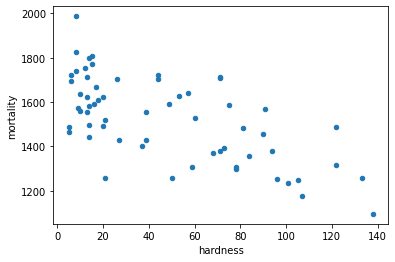

In [ ]:
df.plot(kind='scatter', x='hardness', y='mortality')

На точечном графике наблюдается отсутствие хаотичности. Значения не попадают в область "высокая смертность - высокая жесткость воды", и Энизкая смертность - низкая жесткость, что позволяет предположить наличие обратной корреляции между этими факторами 

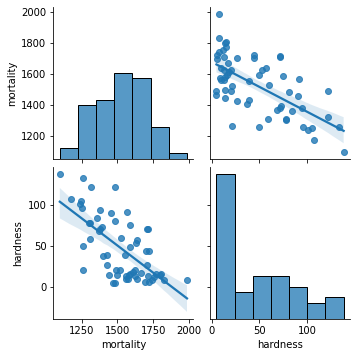

In [ ]:
sns.pairplot(df[['mortality', 'hardness']], kind='reg')

#####  для проверки распределения выборки данных построим график квантиль-квантиль, график Q-Q 

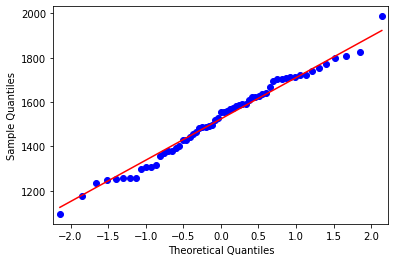

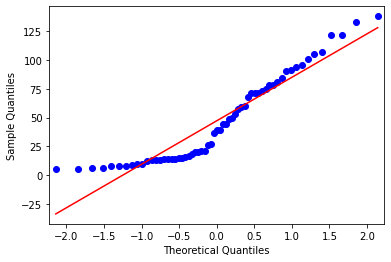

In [ ]:
seed(1)
qqplot(df['mortality'], line='s')
qqplot(df['hardness'], line='s')
pyplot.show()

Судя по графику QQ-plot, распределение mortality блико к нормальному, а распределение hardness - нет

In [ ]:
shapiro_test(df,['mortality', 'hardness'])

mortality
Statistics=0.986, p=0.688
Предположительно нормальное распределение (Недостаточно данных, чтобы отвергнуть H0)

hardness
Statistics=0.888, p=0.000
Отвергаем H0 о нормальности распределения



Наблюдается средняя обратная линейная корреляция (с увеличением жесткости одновременно снижается смертность. Также визуально определяется незначительное количество выбросов ( требуется количественная проверка).
Распределение mortality визуально близко к нормальному, а распределение жесткости - нет. Критерии Шапиро - Уилка это подтверждают. Поэтому коэффициент корреляции Пирсон может быть недостоверным, потребуется дополнительная проверка

##### Попробуем определить выбросы для mortality и hardness

In [ ]:
statis(df,'mortality')

mortality:
Среднее значение по mortality: 1524.1475409836066
Медиана по mortality: 1555.0

Среднее значение по mortality по строкам без выбросов: 1524.1475409836066
Медиана по mortality по строкам без выбросов: 1555.0

Среднее значение по mortality для выбросов: nan
Медиана по mortality для выбросов: nan
% выбросов: 0.0
В mortality выбросов нет


In [ ]:
statis(df,'hardness')

hardness:
Среднее значение по hardness: 47.18032786885246
Медиана по hardness: 39.0

Среднее значение по hardness по строкам без выбросов: 47.18032786885246
Медиана по hardness по строкам без выбросов: 39.0

Среднее значение по hardness для выбросов: nan
Медиана по hardness для выбросов: nan
% выбросов: 0.0
В hardness выбросов нет


Гипотеза о наличии выбросов, проверенная с помощью межквартильного размаха, не подтвердилась

### Расчет коэффициентов корреляции Пирсона и Спирмена 

In [ ]:
# считаем коэф. корреляции Пирсона
df[['hardness', 'mortality']].corr()

,hardness,mortality
hardness,1.000000,-0.654849
mortality,-0.654849,1.000000


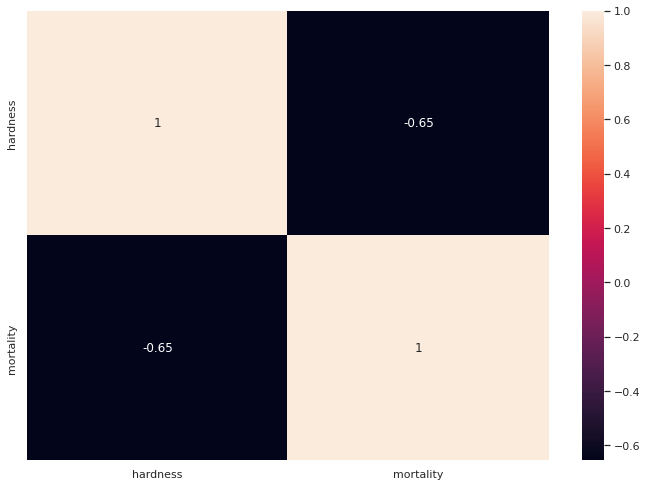

In [ ]:
# коэффициент корреляции на тепловой карте
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df[['hardness', 'mortality']].corr(), annot=True)

Для определения статистической достоверности корреляционной связи r-Пирсона была использована таблица критических значений корреляции Пирсона. https://statpsy.ru/pearson/tablica-pirsona/?ysclid=l9k4a62xb2793082968.

Для данной выборки в 61 элемент для уровня значимости p=0,05 минимальое значение к-та Пирсона =0,25, а для уровня значимости 0,01 =0,33. Полученный к-т статистически достоверен.

In [ ]:
# считаем коэф. корреляции Спирмена
df[['hardness', 'mortality']].corr(method='spearman')

,hardness,mortality
hardness,1.000000,-0.631665
mortality,-0.631665,1.000000


In [ ]:
# считаем коэф. корреляции кендалла
df[['hardness', 'mortality']].corr(method='kendall')

,hardness,mortality
hardness,1.000000,-0.453753
mortality,-0.453753,1.000000


In [ ]:
#уровень значимости коэффициента корреляции Пирсона
sst.pearsonr(df.mortality, df.hardness)

(-0.6548486232042466, 1.0331339260349462e-08)

In [ ]:
#уровень значимости коэффициента корреляции Спирмена между средней годовой смертностью и жёсткостью воды. 
sst.spearmanr(df.mortality, df.hardness)

SpearmanrResult(correlation=-0.6316646189166502, pvalue=4.79546153722838e-08)

Разница в коэффициентах Пирсона и Спирмена - незначительна, Кендалл дает чуть более низкое значение. Расчетные значения коэффициентов подтверждают наличие умеренно сильной обратной корреляции

### Модель линейной регрессии

In [ ]:
X=df[['hardness']]
y=df['mortality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [ ]:
model.coef_

array([-3.65672017])

In [ ]:
model.intercept_

1688.066270653473

##### Уравнение линейной регрессии: Y=-3.66*x + 1668,07

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([1666.12594964, 1640.52890845, 1669.78266981, 1413.81225794,
       1640.52890845, 1629.55874794, 1201.72248811, 1666.12594964,
       1318.73753354, 1358.9614554 , 1355.30473523, 1640.52890845,
       1636.87218828, 1636.87218828, 1552.76762438, 1391.87193693,
       1344.33457472, 1421.12569828, 1428.43913862])

Отобразим на точечной диаграмме тестовые и прогнозные величины, а также линию линейной регрессии

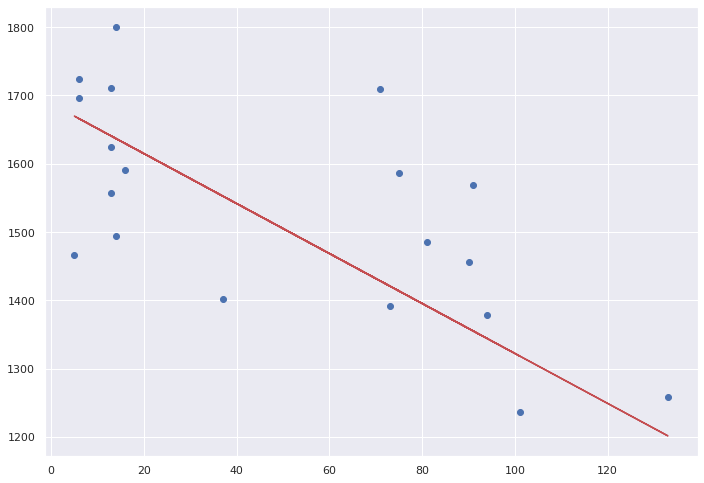

In [ ]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, c='r')

### Расчет коэффициента детерминации модели

In [ ]:
print (f' Коэффициент детерминации: {model.score(X_test, y_test)}') 

 Коэффициент детерминации: 0.30602504827717636


###### R2<0,5 , Линейная регрессионная модель для всей выборки - неудачная. Одна из возможных причин - малый объем выборки ( всего 61 строка). Другая возможная причина - что мы строили модель зависимости только от одного фактора - жесткости воды, а на самом деле такой зависимости в природе нет. Это старый датасет, по нему нельзя делать выводы в настоящее время. Установлено, что существует обратная зависимость между жесткостью воды и смертностью от сердечно-сосудистых заболеваний, но дело не в жесткости воды как таковой, а в содержании  в ней микроэлементов (магний, хром, ванадий, цинк и марганец), которых в жесткой воде обычно больше. Но в данном датасете нет информации и содержании в воде таких микроэлементов, а также нет данных о причинах смертей населения. В развитых странах смертность от сердечно-сусудистых заболеваний, которая напрямую коррелирует с жесткостью воды, составляет около 50%

### График остатков

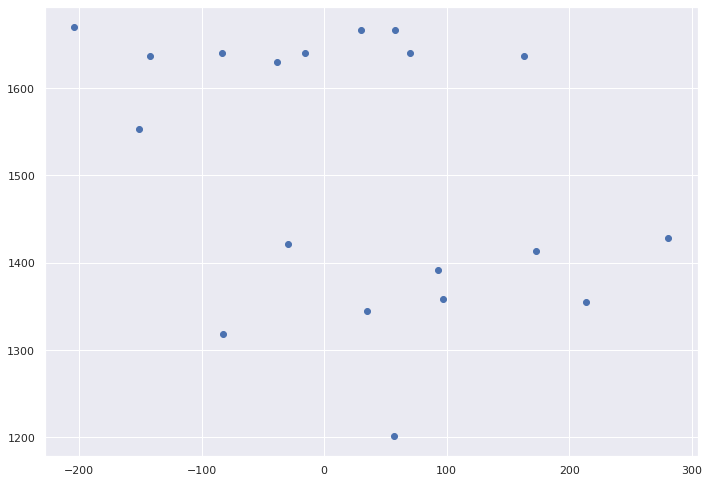

In [ ]:
residuals = y_test-y_pred
plt.scatter(residuals,y_pred)
plt.show()

###### Гистограмма остатков

(array([2., 1., 2., 3., 4., 3., 1., 2., 1.]),
 array([-203.78266981, -149.9667219 ,  -96.15077399,  -42.33482608,
          11.48112183,   65.29706974,  119.11301765,  172.92896556,
         226.74491347,  280.56086138]),
 <a list of 9 Patch objects>)

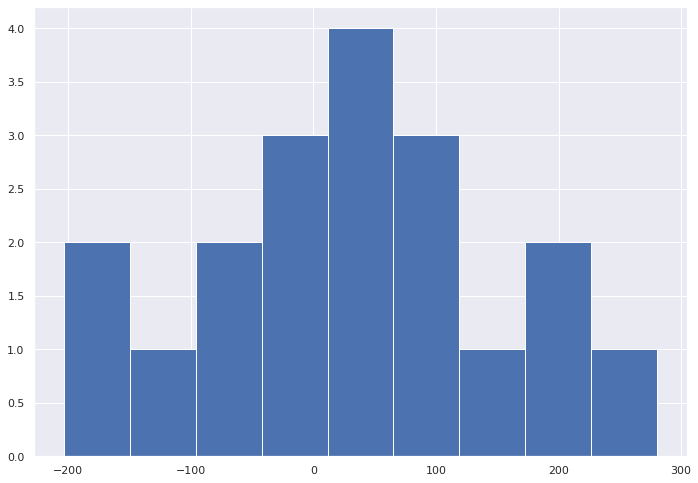

In [ ]:
plt.hist(residuals, bins = 9)

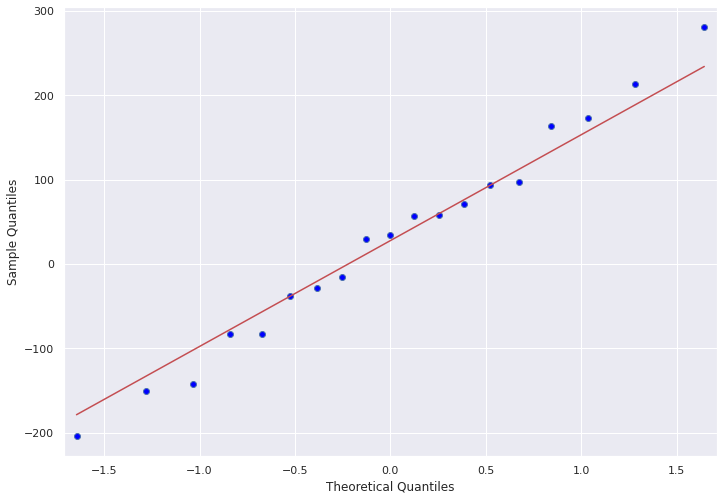

In [ ]:
seed(1)
qqplot(residuals, line='s')
pyplot.show()

#### Альтернативный способ


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
X_const = sm.add_constant(X_train) # техническая особенность библиотеки, надо руками добавить константу

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
X_const


,const,hardness
4,1.0,18
44,1.0,49
19,1.0,21
47,1.0,68
52,1.0,57
25,1.0,138
57,1.0,53
15,1.0,20
58,1.0,122
27,1.0,37


In [ ]:
model = sm.OLS(y_train, X_const)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              mortality   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     26.31
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           7.83e-06
Time:                        12:03:02   Log-Likelihood:                -269.10
No. Observations:                  42   AIC:                             542.2
Df Residuals:                      40   BIC:                             545.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1668.9723     36.543     45.671      0.0

In [ ]:
print('Parameters: ', results.params)
print('R2: ', results.rsquared)

Parameters:  const       1668.972298
hardness      -3.131671
dtype: float64
R2:  0.3967890100912278


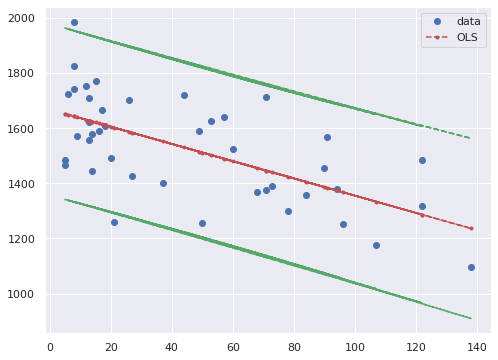

In [ ]:
prstd, iv_l, iv_u = wls_prediction_std(results) 
# для каждой точки получаем не просто сам прогноз, но и доверительный интервал
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X_const.iloc[:, 1], y_train, 'o', label="data")
ax.plot(X_const.iloc[:, 1], results.fittedvalues, 'r--.', label="OLS")
ax.plot(X_const.iloc[:, 1], iv_u, 'g--')
ax.plot(X_const.iloc[:, 1], iv_l, 'g--')
ax.legend(loc='best')

На точечной диаграмме видно, что 2 точки выходят за пределы доверительного интервала. Но в целом модель из ststmodels лучше описывает датасет, R2=0,39> R2=0,31

###### Построим гистограмму распределения ошибок

(array([1., 0., 1., 0., 2., 5., 3., 2., 5., 3., 2., 2., 5., 3., 2., 4., 0.,
        1., 0., 1.]),
 array([-3.43207209e+02, -3.08892795e+02, -2.74578382e+02, -2.40263968e+02,
        -2.05949554e+02, -1.71635140e+02, -1.37320726e+02, -1.03006312e+02,
        -6.86918979e+01, -3.43774840e+01, -6.30700817e-02,  3.42513439e+01,
         6.85657578e+01,  1.02880172e+02,  1.37194586e+02,  1.71509000e+02,
         2.05823414e+02,  2.40137827e+02,  2.74452241e+02,  3.08766655e+02,
         3.43081069e+02]),
 <a list of 20 Patch objects>)

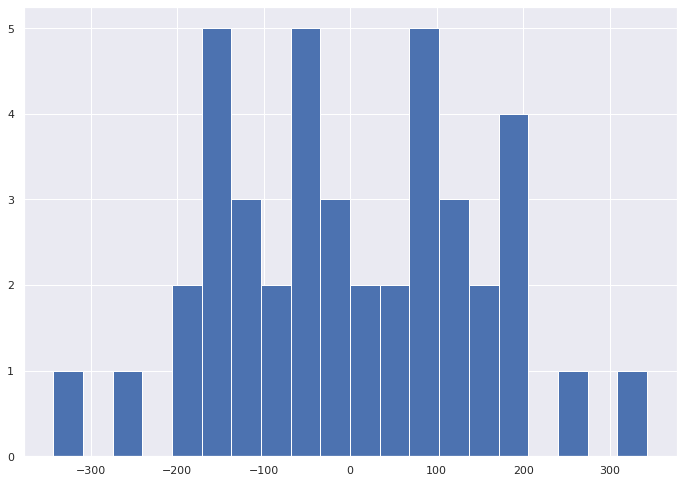

In [ ]:
plt.hist(results.resid, bins=20)


Гистограмма остатков не имеет нормальное распределение

In [ ]:
shapiro_test(results.resid)

Statistics=0.990, p=0.964
4      -3.602222
44     75.479575
19   -343.207209
47    -87.018678
52    149.532942
25   -140.801717
57    124.006258
15   -115.338880
58    199.091549
27   -151.100475
9     -46.911944
30    116.451145
36     73.817728
26    -27.865564
24    185.009752
43   -181.128906
11    123.607753
32    -44.128906
54     -3.260576
56     45.927955
37   -158.883514
29    184.081069
45    343.081069
1      52.266107
21      4.404764
2    -187.313943
48   -255.388754
39     68.878081
35   -157.417184
23    -66.787260
50    266.376334
10    -48.360324
22     98.081069
18     31.091549
60    -68.623666
20    191.821221
7    -125.701970
42     82.739424
14   -114.331894
28    150.002765
51    -71.260576
38   -167.313943
dtype: float64: Предположительно нормальное распределение (Недостаточно данных, чтобы отвергнуть H0)


## Задание 2

### Cохраняется ли аналогичная зависимость для северных и южных городов по отдельности?

#### Разделение датасета на 2 группы - северные и южные города

In [ ]:
df_north=df[df['location']=='North']
df_north.head()

,Unnamed: 0,location,town,mortality,hardness
1,2,North,Birkenhead,1668,17
3,4,North,Blackburn,1800,14
4,5,North,Blackpool,1609,18
5,6,North,Bolton,1558,10
6,7,North,Bootle,1807,15


In [ ]:
df_south=df[df['location']=='South']
df_south.head()

,Unnamed: 0,location,town,mortality,hardness
0,1,South,Bath,1247,105
2,3,South,Birmingham,1466,5
7,8,South,Bournemouth,1299,78
9,10,South,Brighton,1359,84
10,11,South,Bristol,1392,73


#### Проверка нормальности распределения фактора и таргета внутри групп по регионам

In [ ]:
print('mortality:')
print('============================================')
print(df.groupby('location')['mortality'].apply(sst.shapiro))
print()
print('hardness:')
print('============================================')
print(df.groupby('location')['hardness'].apply(sst.shapiro))

mortality:
location
North     (0.9755439758300781, 0.611705482006073)
South    (0.9657907485961914, 0.5180076360702515)
Name: mortality, dtype: object

hardness:
location
North    (0.8113889098167419, 3.4388271160423756e-05)
South        (0.9556195139884949, 0.3126726746559143)
Name: hardness, dtype: object


Н0 о нормальности распределения для mortality по каждой из групп не отвергаем. Для hardness: H0 для севера отвергаем, для юга - нет

In [ ]:
#В каком регионе (Юг, Север) выше средняя смертность?
df.groupby('location').mortality.mean()

location
North    1633.600000
South    1376.807692
Name: mortality, dtype: float64

In [ ]:
#проверка гипотезы H0 о равенстве математических ожиданий в 2 выборках по уровню смертности на севере и юге. Значима ли разница в средних згначениях между этими группами? - да, значима
# для hardness проверить этим способом не можем, т.к H0 о нормальности распределения для севеа отвергли
# применим T-test for the means of two independent samples of scores c опциями ( дисперсии у севера и юга - разные, считала ниже в соотв. разделах)
sst.ttest_ind(df_north.mortality, df_south.mortality, alternative = 'greater',equal_var= False)

Ttest_indResult(statistic=7.142740418007885, pvalue=1.2921579488095343e-09)

Согласно тесту, H0 о равенстве средних по смертности на севере и юге отвергается. Гипотеза сдвига о том, что смертность в южных городах выше, чем в северных, также отвергается (pvalue <0.05).Хотя это видно из расчитанных средних по выборкам

In [ ]:
t_test_verbose(df_north.mortality, sample2=df_south.mortality, fn=sst.ttest_ind) #t-тест Уэлша

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  if __name__ == '__main__':


{'p-значение': 2.5843158976190685e-09,
 'степени свободы     ': 53.289711070938786,
 'интервал уверенности': (1586.5605251961385, 1680.6394748038613),
 'n1          ': 35,
 'n2          ': 26,
 'среднее x   ': 1633.6,
 'среднее y   ': 1376.8076923076924,
 'дисперсия x ': 18751.717647058824,
 'дисперсия y ': 19675.44153846154,
 't-статистика': 7.142740418007885}

#### Северные города

In [ ]:
df_north.info() # В группе чуть больше половины всех записей

In [ ]:
get_stat(df_north,['mortality','hardness'])

In [ ]:
statis(df_north,'mortality')
print()
statis(df_north,'hardness')

##### Есть ли различия в данных выборки?

In [ ]:
#В каком городе наибольшая смертность?
df_north[df_north.mortality == max(df_north.mortality)]
df_north.iloc[df_north.mortality.argmax(), :]

Unnamed: 0         46
location        North
town          Salford
mortality        1987
hardness            8
Name: 45, dtype: object

In [ ]:
#В каком городе минимальная смертность?
df_north[df_north.mortality ==min(df_north.mortality)]
df_north.iloc[df_north.mortality.argmin(), :]

Unnamed: 0       61
location      North
town           York
mortality      1378
hardness         71
Name: 60, dtype: object

Как видно из расчетов, В Йорке с очень жесткой водой (hardness = 71) смертность почти в 1,5 раза меньше, чем в Сэлфорде, где жесткость самая низкая (8)

##### Построение точечного графика

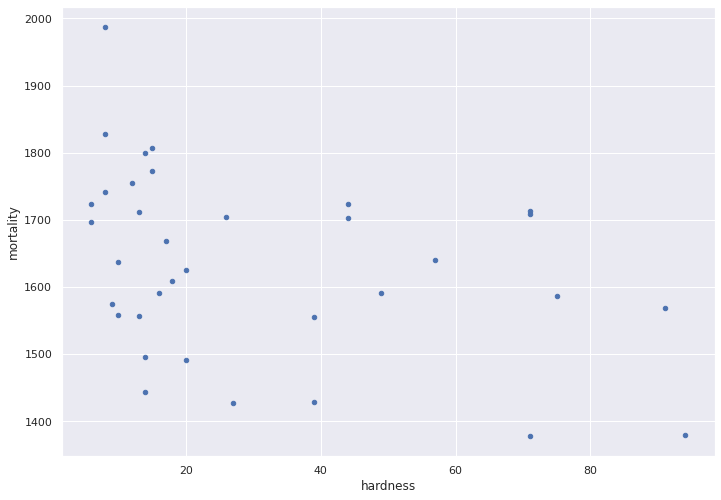

In [ ]:
df_north.plot(kind='scatter', x='hardness', y='mortality')

На точечном графике можно увидеть отсутствие хаотичности. Как и на точечном графике основной выборки, значения практически не попадают выше воображаемой диагонали (область высоких значений жесткости и высоких значений смертности). В то же время, Расположение точек сдвинуто в область низких згпчений жесткости, что косвеоо подтверждает более низкую жесткость воды на севере.

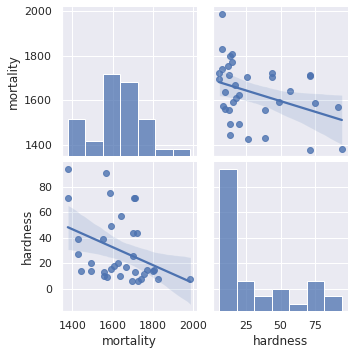

In [ ]:
sns.pairplot(df_north[['mortality', 'hardness']], kind='reg')

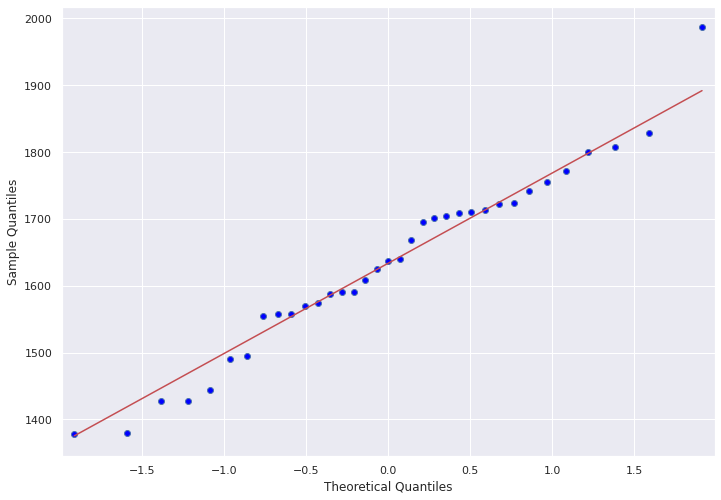

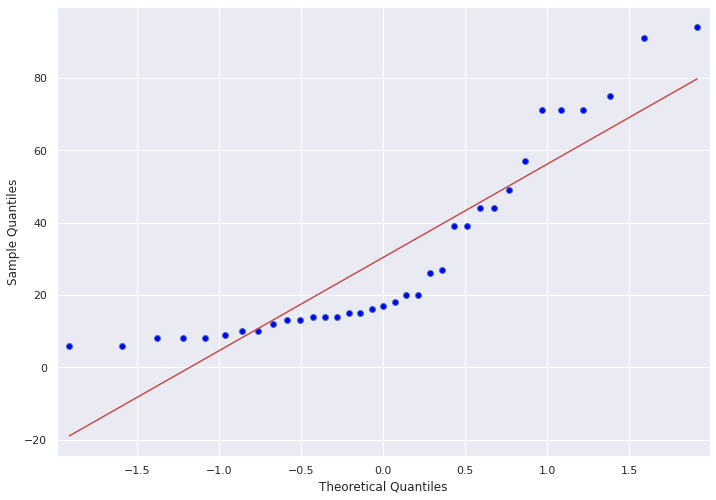

In [ ]:
seed(1)
qqplot(df_north['mortality'], line='s')
qqplot(df_north['hardness'], line='s')
pyplot.show()

Получено визуальное подтверждение сделанной ранее гипотезы о нормальности распределения mortality и отсутствии нормальности - для hardness

In [ ]:
shapiro_test(df_north,['mortality', 'hardness'])

mortality
Statistics=0.976, p=0.612
Предположительно нормальное распределение (Недостаточно данных, чтобы отвергнуть H0)

hardness
Statistics=0.811, p=0.000
Отвергаем H0 о нормальности распределения



Наблюдается средняя обратная линейная корреляция (с увеличением жесткости одновременно снижается смертность. Также визуально определяется незначительное количество выбросов ( требуется количественная проверка).
Распределение mortality визуально близко к нормальному, а распределение жесткости - нет. Критерии Шапиро - Уилка это подтверждают. Поэтому коэффициент корреляции Пирсон может быть недостоверным, потребуется дополнительная проверка

##### Попробуем определить выбросы для mortality и hardness

In [ ]:
statis(df_north,'mortality')

mortality:
Среднее значение по mortality: 1633.6
Медиана по mortality: 1637.0

Среднее значение по mortality по строкам без выбросов: 1623.2058823529412
Медиана по mortality по строкам без выбросов: 1631.0

Среднее значение по mortality для выбросов: 1987.0
Медиана по mortality для выбросов: 1987.0
% выбросов: 2.86


In [ ]:
statis(df_north,'hardness')

hardness:
Среднее значение по hardness: 30.4
Медиана по hardness: 17.0

Среднее значение по hardness по строкам без выбросов: 28.529411764705884
Медиана по hardness по строкам без выбросов: 16.5

Среднее значение по hardness для выбросов: 94.0
Медиана по hardness для выбросов: 94.0
% выбросов: 2.86


Гипотеза о наличии выбросов, проверенная с помощью межквартильного размаха, подтвердилась

##### Расчет коэффициентов корреляции Пирсона и Спирмена

In [ ]:
# считаем коэф. корреляции Пирсона
df_north[['hardness', 'mortality']].corr()

,hardness,mortality
hardness,1.000000,-0.368598
mortality,-0.368598,1.000000


In [ ]:
# считаем коэф. корреляции Спирмена
df_north[['hardness', 'mortality']].corr(method='spearman')

,hardness,mortality
hardness,1.000000,-0.404208
mortality,-0.404208,1.000000


In [ ]:
# считаем коэф. корреляции кендалла
df_north[['hardness', 'mortality']].corr(method='kendall')

,hardness,mortality
hardness,1.000000,-0.283058
mortality,-0.283058,1.000000


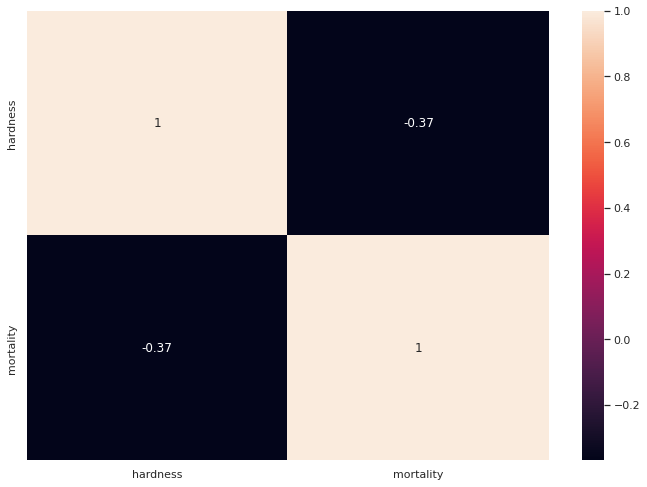

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df_north[['hardness', 'mortality']].corr(), annot=True)

Для северных городов наблюдается слабо выраженная обратная корреляция между жесткостью воды и смертностью. Коэффициент корреляции даже меньше, чем для выборки в целом

##### Модель линейной регрессии

In [ ]:
X=df_north[['hardness']]
y=df_north['mortality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
model.coef_

array([-3.32783181])

In [ ]:
model.intercept_

1702.3658062157222

Уравнение линейной регрессии: Y=-3.33*x + 1702.37

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([1399.53311152, 1555.94120658, 1669.08748812, 1466.08974771,
       1635.80917002, 1452.77842048, 1682.39881536, 1655.77616088,
       1675.74315174, 1466.08974771, 1675.74315174])

Отобразим на точечной диаграмме тестовые и прогнозные величины, а также линию линейной регрессии

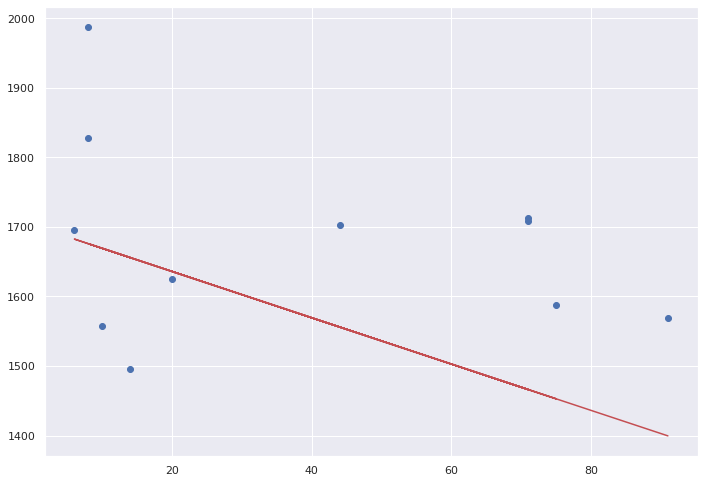

In [ ]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, c='r')

Визуально модель линейной регресссии не подходит. Зависимость выглядит как нелинейная

##### Расчет коэффициента детерминации

In [ ]:
print (f' Коэффициент детерминации: {model.score(X_test, y_test)}') 

 Коэффициент детерминации: -0.8059562565000893


##### График остатков

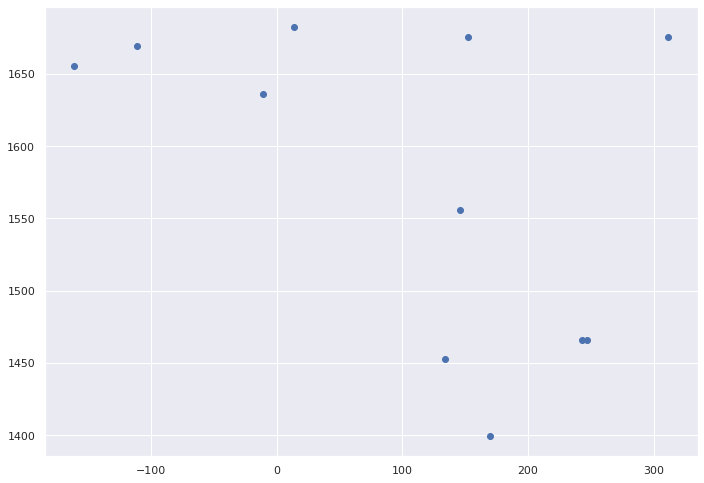

In [ ]:
residuals = y_test-y_pred
plt.scatter(residuals,y_pred)
plt.show()

###### Гистограмма остатков

(array([1., 1., 0., 2., 0., 0., 4., 0., 2., 1.]),
 array([-160.77616088, -113.57285996,  -66.36955905,  -19.16625814,
          28.03704278,   75.24034369,  122.44364461,  169.64694552,
         216.85024644,  264.05354735,  311.25684826]),
 <a list of 10 Patch objects>)

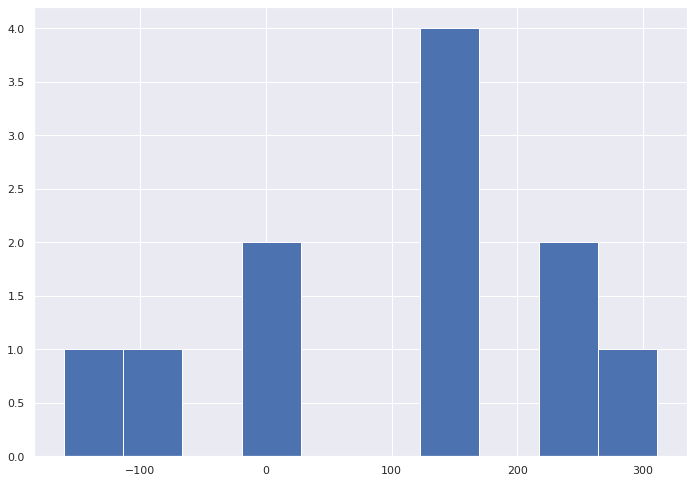

In [ ]:
plt.hist(residuals)

Для группы северных городов модель линейной регрессии, очевидно, не подходит - к-т детерминации <0, гистограмма остатков не имеет нормальное распределение

#### Южные города

In [ ]:
df_south.info() # В группе чуть меньше половины всех записей

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 59
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  26 non-null     int64 
 1   location    26 non-null     object
 2   town        26 non-null     object
 3   mortality   26 non-null     int64 
 4   hardness    26 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 1.2+ KB


In [ ]:
get_stat(df_south,['mortality','hardness'])

mortality:
count = 26, max = 1627, min = 1096, range = 531, mean = 1376.8076923076924, mediana = 1364.0,  mode = 1486, std = 140.26917529686108, var = 19675.44153846154, Q1 = 1259.25,  Q3 = 1485.75, IQR = 226.5
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
hardness:
count = 26, max = 138, min = 5, range = 133, mean = 69.76923076923077, mediana = 75.5,  mode = 5, std = 40.36068155252851, var = 1628.9846153846154, Q1 = 40.25,  Q3 = 99.75, IQR = 59.5
-------------------------------------------------------------------------------------------------------------------------------------------------------------------


### Есть ли различия в данных выборки?

In [ ]:
#В каком городе наибольшая смертность?
df_south[df_south.mortality == max(df_south.mortality)]
df_south.iloc[df_south.mortality.argmax(), :]

Unnamed: 0               58
location              South
town          West Bromwich
mortality              1627
hardness                 53
Name: 57, dtype: object

In [ ]:
#В каком городе минимальная смертность?
df_south[df_south.mortality ==min(df_north.mortality)]
df_south.iloc[df_south.mortality.argmin(), :]

Unnamed: 0         26
location        South
town          Ipswich
mortality        1096
hardness          138
Name: 25, dtype: object

Как видно из расчетов, В Западном Бромвиче с очень жесткой водой (hardness = 53) смертность почти в 1,5 раза меньше, чем в Ипсвиче, где жесткость самая низкая (8)

##### Построение точечного графика

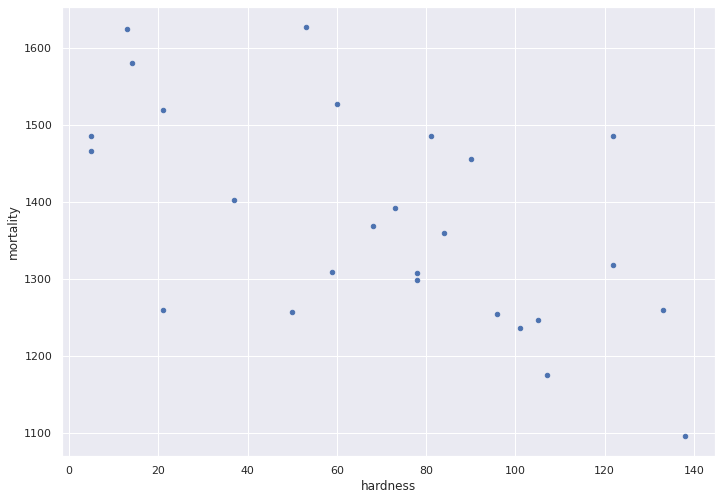

In [ ]:
df_south.plot(kind='scatter', x='hardness', y='mortality')

На точечном графике значения распределены более хаотично по сравнению с графиком для севера. Факторы не попадают в области " высокая жесткость - высокая смертность" и "низкая жесткость - низкая смертность", что позволяет предположить наличие обратной корреляции междлу факторами, более сильной, чем на севере

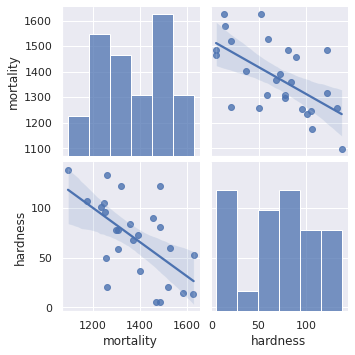

In [ ]:
sns.pairplot(df_south[['mortality', 'hardness']], kind='reg')

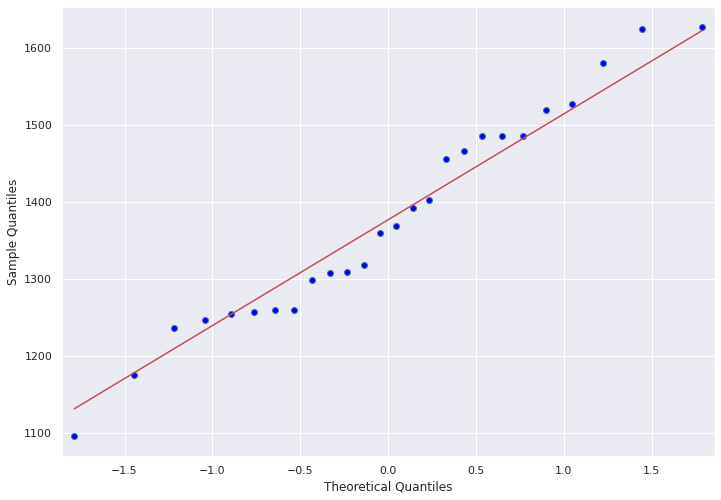

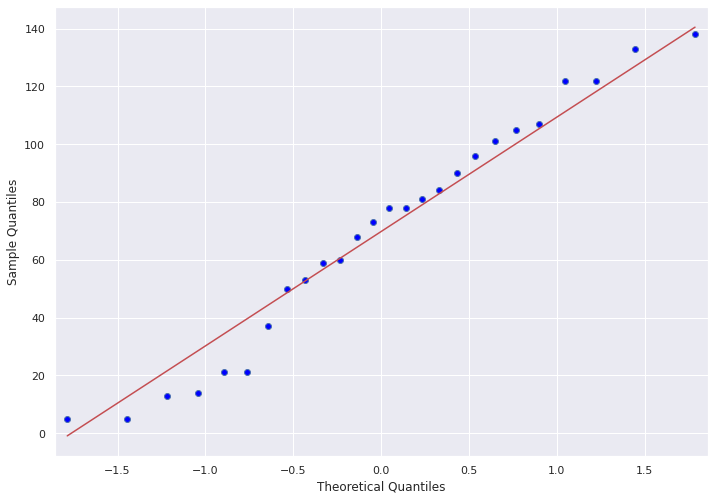

In [ ]:
seed(1)
qqplot(df_south['mortality'], line='s')
qqplot(df_south['hardness'], line='s')
pyplot.show()

Получено визуальное подтверждение сделанной ранее гипотезы о нормальности распределения mortality и hardness на юге

In [ ]:
shapiro_test(df_south,['mortality', 'hardness'])

mortality
Statistics=0.966, p=0.518
Предположительно нормальное распределение (Недостаточно данных, чтобы отвергнуть H0)

hardness
Statistics=0.956, p=0.313
Предположительно нормальное распределение (Недостаточно данных, чтобы отвергнуть H0)



Наблюдается средняя обратная линейная корреляция (с увеличением жесткости одновременно снижается смертность. Также визуально определяется незначительное количество выбросов (требуется количественная проверка).
Распределения mortality и hardness визуально близко к нормальному. Критерии Шапиро - Уилка это подтверждают.

##### Попробуем определить выбросы для mortality и hardness

In [ ]:
statis(df_south,'mortality')
print()
statis(df_south,'hardness')

mortality:
Среднее значение по mortality: 1376.8076923076924
Медиана по mortality: 1364.0

Среднее значение по mortality по строкам без выбросов: 1376.8076923076924
Медиана по mortality по строкам без выбросов: 1364.0

Среднее значение по mortality для выбросов: nan
Медиана по mortality для выбросов: nan
% выбросов: 0.0
В mortality выбросов нет

hardness:
Среднее значение по hardness: 69.76923076923077
Медиана по hardness: 75.5

Среднее значение по hardness по строкам без выбросов: 69.76923076923077
Медиана по hardness по строкам без выбросов: 75.5

Среднее значение по hardness для выбросов: nan
Медиана по hardness для выбросов: nan
% выбросов: 0.0
В hardness выбросов нет


При нормальном распределении и отсутствии выбросом вожно рассчитывать на достоверность коэффициента корреляции Пирсона

##### Расчет коэффициентов корреляции Пирсона и Спирмена

In [ ]:
# считаем коэф. корреляции Пирсона
df_south[['hardness', 'mortality']].corr()

,hardness,mortality
hardness,1.000000,-0.602153
mortality,-0.602153,1.000000


In [ ]:
# считаем коэф. корреляции Спирмена
df_south[['hardness', 'mortality']].corr(method='spearman')

,hardness,mortality
hardness,1.000000,-0.595723
mortality,-0.595723,1.000000


In [ ]:
# считаем коэф. корреляции кендалла
df_south[['hardness', 'mortality']].corr(method='kendall')

,hardness,mortality
hardness,1.000000,-0.440315
mortality,-0.440315,1.000000


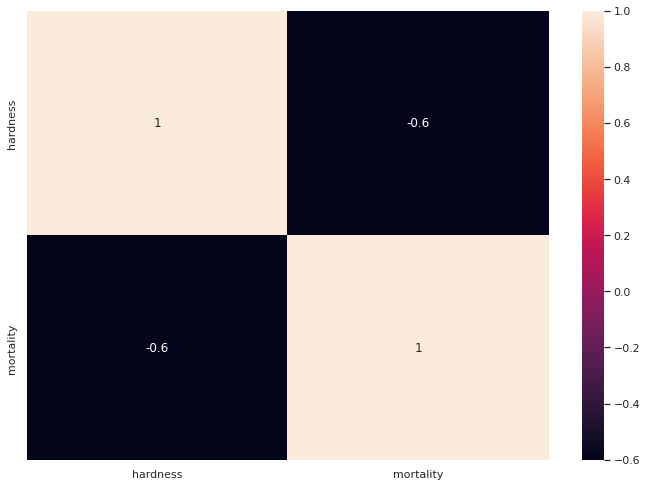

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df_south[['hardness', 'mortality']].corr(), annot=True)

Гипотеза о более сильной обратной корреляции на юге, чем на севере, подтвердилась. Для группы южных городов коэффициент корреляции, рассчитанный по всем 3 методикам, больше, чем на севере и в целом по выборке. 

##### Модель линейной регрессии

In [ ]:
X=df_south[['hardness']]
y=df_south['mortality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
model.coef_

array([-1.87359315])

In [ ]:
model.intercept_

1520.492357120051

Уравнение линейной регрессии: Y=-1.87*x + 1520.49

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([1331.25944883, 1409.95036119, 1351.8689735 , 1363.11053241,
       1408.07676804, 1261.93650223, 1393.08802283, 1426.81269955])

Отобразим на точечной диаграмме тестовые и прогнозные величины, а также линию линейной регрессии

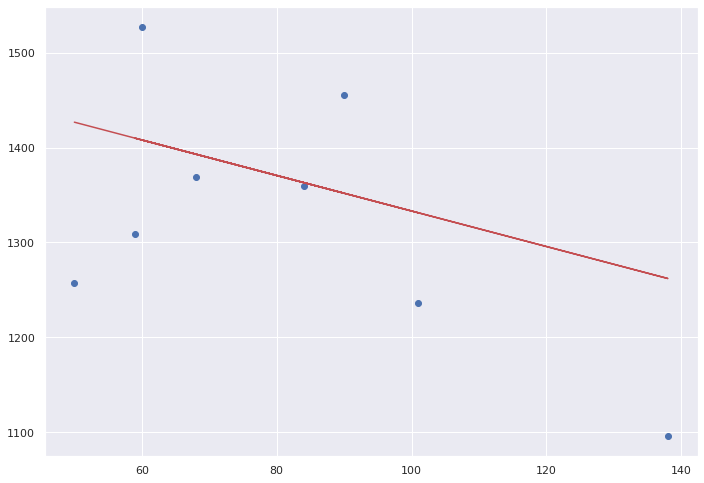

In [ ]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, c='r')

Визуально кажется, что, как и в случае с севером,  зависимость  нелинейная, и рассчитанная модель линейной регрессии выглядит неподходящей

##### Расчет коэффициента детерминации

In [ ]:
print (f' Коэффициент детерминации: {model.score(X_test, y_test)}') 

 Коэффициент детерминации: 0.19850621188305384


##### График остатков

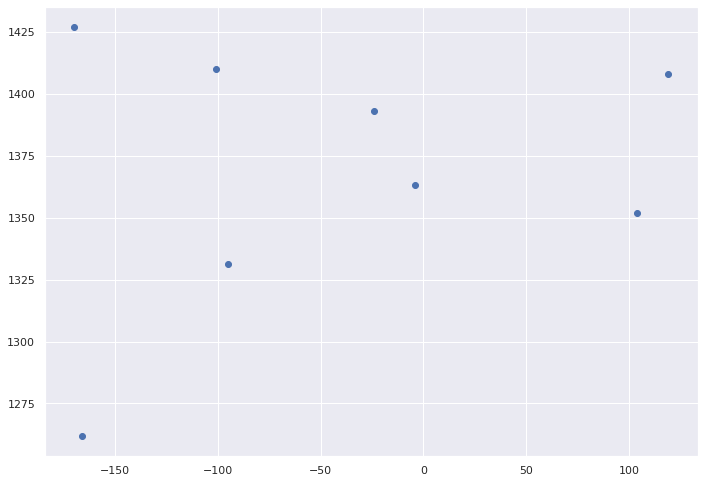

In [ ]:
residuals = y_test-y_pred
plt.scatter(residuals,y_pred)
plt.show()

###### Гистограмма остатков

(array([2., 0., 2., 0., 0., 2., 0., 0., 0., 2.]),
 array([-169.81269955, -140.9391064 , -112.06551325,  -83.1919201 ,
         -54.31832695,  -25.4447338 ,    3.42885936,   32.30245251,
          61.17604566,   90.04963881,  118.92323196]),
 <a list of 10 Patch objects>)

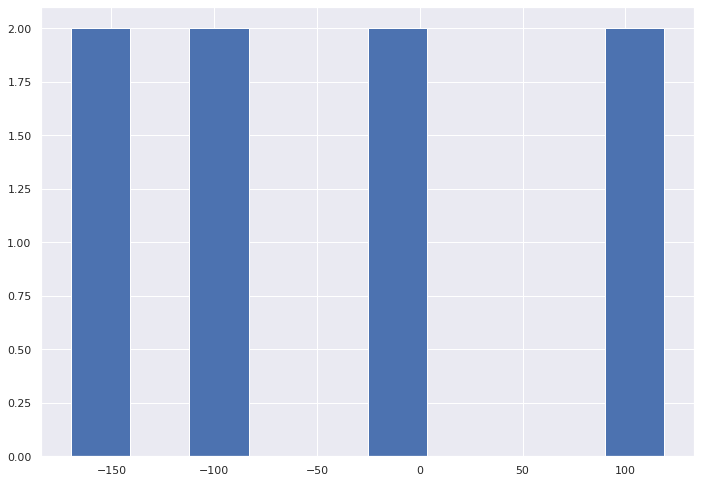

In [ ]:
plt.hist(residuals)

Для группы южных городов модель линейной регрессии, очевидно, не подходит - к-т детерминации 0.19 <0.5, гистограмма остатков не имеет нормальное распределение